<a href="https://colab.research.google.com/github/SpirinEgor/HSE.Deep_Unsupervised_Learning/blob/hw13/Homework/hw13/Homework13_realnvp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! nvidia-smi

Tue Mar  8 20:53:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
! if [ -d HSE.Deep_Unsupervised_Learning ]; then rm -Rf HSE.Deep_Unsupervised_Learning; fi
! git clone https://github.com/SpirinEgor/HSE.Deep_Unsupervised_Learning.git
%cd HSE.Deep_Unsupervised_Learning
! git checkout hw13

Cloning into 'HSE.Deep_Unsupervised_Learning'...
remote: Enumerating objects: 1306, done.
remote: Counting objects: 100% (308/308), done.
remote: Compressing objects: 100% (169/169), done.
remote: Total 1306 (delta 194), reused 162 (delta 137), pack-reused 998
Receiving objects: 100% (1306/1306), 94.80 MiB | 13.50 MiB/s, done.
Resolving deltas: 100% (665/665), done.
Checking out files: 100% (89/89), done.
/content/HSE.Deep_Unsupervised_Learning
Branch 'hw13' set up to track remote branch 'hw13' from 'origin'.
Switched to a new branch 'hw13'


In [3]:
! pip install -q -r requirements.txt

In [1]:
%cd ../..

/Users/Egor.Spirin/HSE/HSE.Deep_Unsupervised_Learning


In [2]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

from realnvp.train import RealNVPTrainer
from utils.hw13_utils import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
plt.rcParams["axes.labelsize"] = 25.0
plt.rcParams["xtick.labelsize"] = 20.0
plt.rcParams["ytick.labelsize"] = 20.0
plt.rcParams["legend.fontsize"] = 18.0

plt.rcParams["figure.figsize"] = [8.0, 6.0]

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Question 1: RealNVP on Higher Dimensions


In this problem, you will train a flow model to invertibly map a high dimensional dataset of celebrity faces to gaussian noise.
The dataset is a low-resolution (32 × 32) version of the CelebA-HQ dataset that has been quantized to 2 bits per color channel.

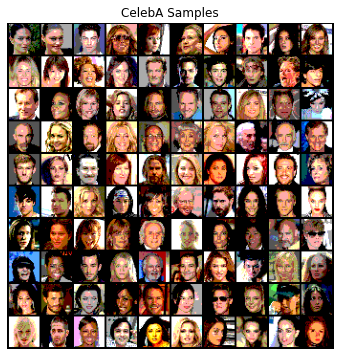

In [5]:
visualize_q1_data()

## Part (a): RealNVP


Use the affine coupling flow from RealNVP and a form of [data-dependent initialization](https://arxiv.org/abs/1602.07868) that normalizes activations from an initial forward pass with a minibatch.
We describe a reference architecture below that can achieve good performance, but you are free
and encouraged to use different architectures and/or structure your code differently.



```
Preprocess() # dequantization, logit trick from RealNVP (Dinh et al) Section 4.1

for _ in range(4):
  AffineCouplingWithCheckerboard() # Figure 3 in Dinh et al - (left)
  ActNorm() # described in Glow (Kingma & Dhariwal) Section 3.1
Squeeze(), # [b, c, h, w] --> [b, c*4, h//2, w//2]

for _ in range(3):
  AffineCouplingWithChannel()
  ActNorm()
Unsqueeze(), # [b, c*4, h//2, w//2] --> [b, c, h, w]

for _ in range(3):
  AffineCouplingWithCheckerboard()
  ActNorm()
```



Here, we provide pseudocode for the basic structure of each coupling layer. 



```
# pseudocode
ResnetBlock: n_filters
  h = x
  h = conv2d(n_filters, n_filters, (1,1), stride=1, padding=0)(h)
  h = relu(h)
  h = conv2d(n_filters, n_filters, (3,3), stride=1, padding=1)(h)
  h = relu(h)
  h = conv2d(n_filters, n_filters, (1,1), stride=1, padding=0)(h)
  return h + x

SimpleResnet: n_filters = 256, n_blocks = 8, n_out
  conv2d(in_channels, n_filters=128, (3,3), stride=1, padding=1)
  apply 8 ResnetBlocks with n_filters=128
  relu()
  conv2d(n_filters, n_filters=n_out, (3,3), stride=1, padding=1)
  
AffineCoupling(x, mask):
  x_ = x * mask
  log_s, t = torch.chunk(SimpleResnet(x_), 2, dim=1)
  # todo: calculate log_scale, as done in Q1(b)
  t = t * (1.0 - mask)
  log_scale = log_scale * (1.0 - mask)
  z = x * torch.exp(log_scale) + t
  log_det_jacobian = log_scale
  return z, log_det_jacobian
```



We use an Adam Optimizer with a warmup over 200 steps till a learning rate of 5e-4. We didn’t decay the learning rate but it is a generally recommended practice while training generative models. We show samples from our model at the end of training, as well as interpolations between several images in our dataset.  Our reference solution achieves a test loss of about 0.40 bits/dim after 100 epochs. 



**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model
4. 5 rows of interpolations between images in the test set; each row consists of the start and end images, and 4 intermediate ones. You should return 30 total images. 



### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [13]:
class CelebDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data.astype(float) / 3  # img are {0, 1, 2, 3}
        self.transforms = transforms.Compose([transforms.ToTensor(), transforms.RandomHorizontalFlip()])

    def __len__(self):
        return 100  # self.data.shape[0]

    def __getitem__(self, index):
        return self.transforms(self.data[index]).float()


def q1_a(train_data, test_data):
    """
    train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 3) of samples with values in [0, 1]
    - a numpy array of size (30, H, W, 3) of interpolations with values in [0, 1].
    """
    train_dataset = CelebDataset(train_data)
    test_dataset = CelebDataset(test_data)

    train_dataloader = DataLoader(train_dataset, batch_size=12, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=12)

    trainer = RealNVPTrainer(device, hidden_dim=64)

    train_losses, test_losses = trainer.fit(train_dataloader, test_dataloader, 1)
    samples = trainer.sample(100)

    images = torch.stack([test_dataset[it] for it in range(10)])
    interpolations = trainer.interpolate(images)

    return train_losses, test_losses, samples, interpolations

### Results

Once you've implemented `q1_a`, execute the cells below to visualize and save your results



Testing:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/1 [00:00<?, ?it/s]

Testing:   0%|          | 0/9 [00:00<?, ?it/s]

Test loss: 0.9664720495541891
Final Test Loss: 0.9665


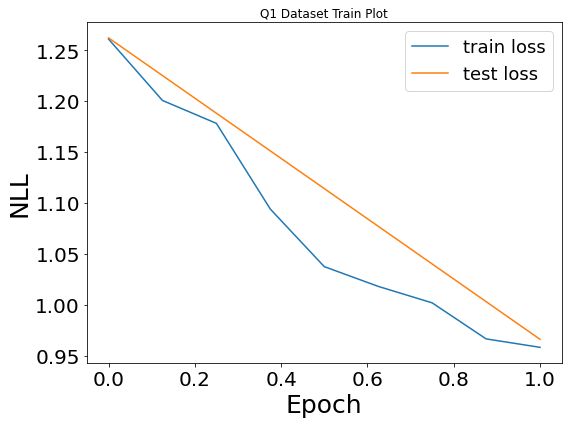

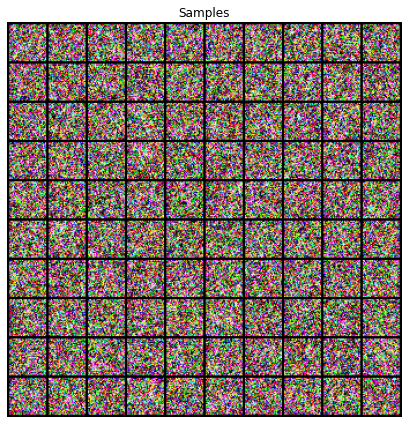

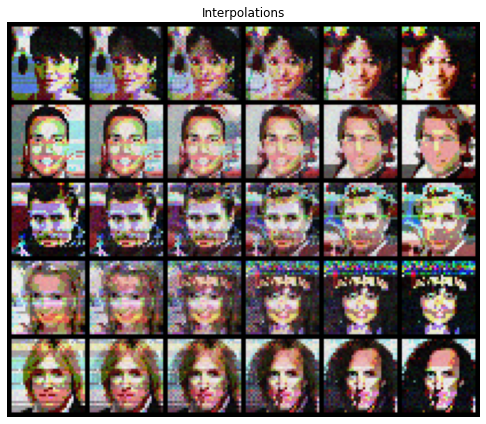

In [14]:
q1_save_results(q1_a, "a")

## Part (b): Exploring bad masking schemes

The choice of masking or partitioning scheme affects the quality of the final flow model. In this part, design a *bad* masking scheme and train a model with it on the same CelebA dataset. 

**Provide the same deliverables as part (a)**

### Solution

In [ ]:
def q1_b(train_data, test_data):
    """
    train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, 3, H, W) of samples with values in [0, 1]
    - a numpy array of size (30, 3, H, W) of interpolations with values in [0, 1].
    """

    """ YOUR CODE HERE """
    pass

### Results

Once you've implemented `q1_b`, execute the cells below to visualize and save your results



torch.Size([30, 3, 32, 32])
Final Test Loss: 0.6963


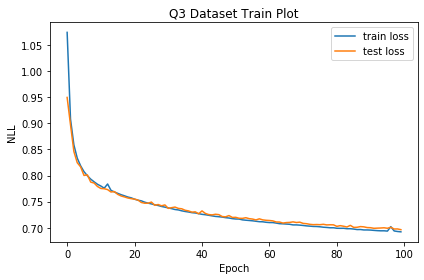

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


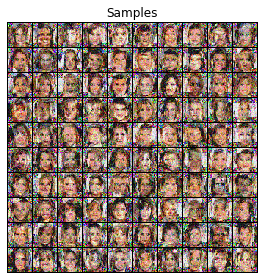

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


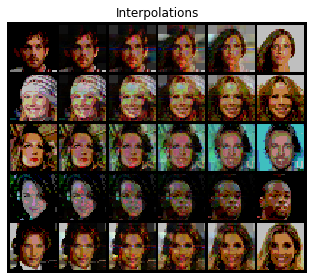

In [ ]:
q1_save_results(q1_b, "b")

## Bonus 1: Multiscale RealNVP
Following the alternating checkerboard, channel squeeze, and channel partition scheme used in https://arxiv.org/abs/1605.08803, learn a multiscale RealNVP model on our CelebA dataset used in Question 3. We expect the same deliverables as in Question 3; additionally, make sure to include analysis on any difference in qualitative or quantitative differences you see in the results.

In [ ]:
def b1(train_data, test_data):
    """
    train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, 3, H, W) of samples with values in [0, 1]
    - a numpy array of size (30, 3, H, W) of interpolations with values in [0, 1].
    """
    pass

In [ ]:
q1_save_results(b1, "bonus1")

## Bonus 2: Glow
The Glow paper introduces the invertible 1x1 convolution as a replacement for the permutation scheme that follows the channel squeezing step. Use this in your model from Question 3, and report the same deliverables. Make sure to include analysis on any difference in qualitative or quantitative differences you see in the results.

In [ ]:
def b2(train_data, test_data):
    """
    train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, 3, H, W) of samples with values in [0, 1]
    - a numpy array of size (30, 3, H, W) of interpolations with values in [0, 1].
    """
    pass

In [ ]:
q1_save_results(b2, "bonus2")